In [144]:
import os
import torch
import numpy as np
import cv2
from speciesnet import DEFAULT_MODEL
from speciesnet import draw_bboxes
from speciesnet import load_rgb_image
from speciesnet import SpeciesNet
from speciesnet import SpeciesNetClassifier
from speciesnet import SUPPORTED_MODELS
from megadetector.visualization import visualization_utils as vis_utils
from megadetector.detection import run_detector
from helper_functions import bbx_from_txt
from helper_functions import plot_labeled_image
from helper_functions import plot_image
from helper_functions import crop_and_save_image_train
import torchvision.transforms.functional as F
from PIL import Image
%matplotlib inline

In [ ]:
# Captum methods

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
# Import models

custom_megadetector_model = run_detector.load_detector('./models/md_v5a.0.0.pt')
species_net = SpeciesNet('./models')
species_net_classifier_model = torch.load('./models/always_crop_99710272_22x8_v12_epoch_00148.pt', weights_only=False)
species_net_classifier_model.eval()

In [92]:
with open('./models/always_crop_99710272_22x8_v12_epoch_00148.labels.txt', mode="r", encoding="utf-8") as fp:
  labels = {idx: line.strip() for idx, line in enumerate(fp.readlines())}

In [3]:
# Create detect image objects function

def detect_image_objects(frame, threshold=0.2, model = custom_megadetector_model):
    result = model.generate_detections_one_image(frame)
    detections = result.get('detections', [])
    # List comprehension for filtered detections, use dict comprehension for concise creation
    filtered = {str(i): {"category": d["category"], "confidence": d["conf"], "bbox": d["bbox"]}
                for i, d in enumerate(detections) if d["conf"] > threshold}
    return filtered

In [115]:
# Show training data

def show_training_data(file_name = None):
    train_path = './images'
    training_files = os.listdir(train_path)
    if file_name is None:
      index = np.random.randint(len(training_files))
      file_name = training_files[index]
    img_path = os.path.join(train_path, file_name)
    file_name_raw = file_name.replace('.jpg', '').replace('.png', '')
    txt_path = os.path.join('./labels', file_name_raw + '.txt')
    if os.path.exists(txt_path):
      with open(txt_path, "r") as input:
        labeled_bbx = input.read()
        labeled_bbx = bbx_from_txt(labeled_bbx)
    else:
      labeled_bbx = []
    frame = cv2.imread(img_path)
    detection_metadata = detect_image_objects(frame, 0.5, model = custom_megadetector_model)
    if len(labeled_bbx) > 0:
      plot_labeled_image(frame, detection_metadata, labeled_bbx) 
    else:
      plot_image(frame, detection_metadata)
    folder_name, to_append = file_name_raw.split('_')
    crop_and_save_image_train(frame, labeled_bbx, folder_name, append = to_append)
    file_name_to_predict = folder_name + '_' + to_append + '.jpg'
    predictions_dict = species_net.classify(
            filepaths=[f'./cropped_images/{folder_name}/{file_name_to_predict}']
        )
    print(f"""Detected metadata:{detection_metadata}\nLabeled metadata:{labeled_bbx}\nImage Shape:{frame.shape[:2]}\nPrediction:{predictions_dict}""")

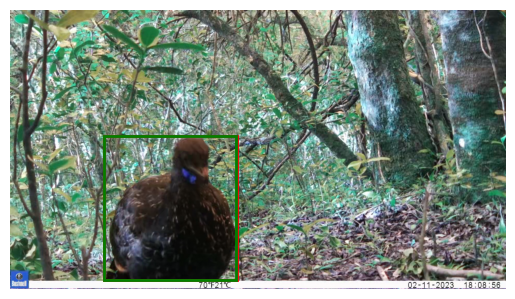

Detected metadata:{'54': {'category': '1', 'confidence': 0.977, 'bbox': [0.1906, 0.4518, 0.2677, 0.5185]}}
Labeled metadata:[[0.0, 0.3239, 0.71055, 0.2666, 0.5175]]
Image Shape:(1080, 1920)
Prediction:{'predictions': [{'filepath': './cropped_images/02110073/02110073_40.jpg', 'classifications': {'classes': ['b1352069-a39c-4a84-a949-60044271c0c1;aves;;;;;bird', '9f152289-08b9-475d-83e3-346d9fbd0297;aves;galliformes;cracidae;penelope;superciliaris;rusty-margined guan', 'a80d55c2-5fdf-4055-b01b-d697421145fb;aves;passeriformes;corvidae;nucifraga;caryocatactes;nutcracker', '4b34e34d-eb25-4345-8ab0-cfa7441c603d;aves;galliformes;cracidae;penelope;;penelope species', '2a54b5b4-1d76-4e1d-97ad-d5cf459d53b3;aves;anseriformes;anatidae;cairina;moschata;muscovy duck'], 'scores': [0.5260550379753113, 0.1516583412885666, 0.06766068935394287, 0.038282833993434906, 0.03154732659459114]}}]}


In [209]:
# Show sample data

show_training_data('02110073_40.jpg')

In [210]:
# Predict using the base model

img = cv2.imread('./cropped_images/02110073/02110073_40.jpg', cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img) 
img_tensor = F.pil_to_tensor(img_pil)
img_tensor = F.convert_image_dtype(img_tensor, torch.float32)
img_tensor = F.resize(
               img_tensor,
               [480, 480],
               antialias=False,
           )
img_tensor = img_tensor.permute([1, 2, 0]).unsqueeze(0)
logits = species_net_classifier_model.forward(img_tensor).cpu()
scores = torch.softmax(logits, dim=-1)
scores, indices = torch.topk(scores, k=5, dim=-1)

In [212]:
target = 2463

In [215]:
def attribute_image_features(algorithm, input, target, **kwargs):
    species_net_classifier_model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target = target
                                              **kwargs
                                             )
    
    return tensor_attributions

In [216]:
saliency = Saliency(species_net_classifier_model)
grads = saliency.attribute(img_tensor, target = target)
grads = grads.squeeze().cpu().detach().numpy()

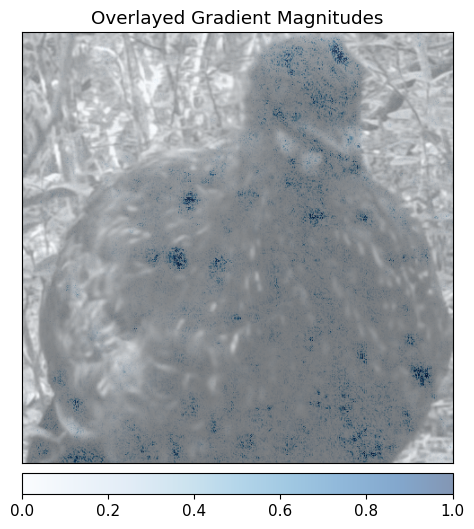

In [217]:
original_image = img_tensor.squeeze(0).detach().numpy()
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")